In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [47]:
df = pd.read_csv('flights_refined.csv')

/Users/zhou/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [48]:
print(len(df))

5819079


In [28]:
df2 = df[["DEPARTURE_DELAY","ARRIVAL_DELAY"]]
df2.dropna(axis=0,how = "any",inplace=True)
X = df2['DEPARTURE_DELAY']
Y = df2['ARRIVAL_DELAY']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
Yhat = model.predict(X) 
model.summary()

<ipython-input-28-9b00d3fd67ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(axis=0,how = "any",inplace=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 4.739e+07
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        17:58:28   Log-Likelihood:            -2.2712e+07
No. Observations:             5714008   AIC:                         4.542e+07
Df Residuals:                 5714006   BIC:                         4.542e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.9404      0.006   -888.981      0.000      -4.951      -4.929
DEPARTURE_DELAY     1.0057      0.000   6884.203      0.000       1.005       1.006
==============================================================================
Omnibus:                  2101438.976   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22626989.674
Skew:                           1.463   Prob(JB):                         0.00
Kurtosis:                      12.299   Cond. No.                         39.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [286]:
df4 = df.copy()
df4 = df4.loc[df4['AIRLINE'] == 'DL']
df4 = df4.loc[df4['ORIGIN_AIRPORT'] == 'JFK']
df4 = df4[['MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_TIME', 'DEPARTURE_DELAY','SCHEDULED_TIME','DISTANCE']]
df4['Hour'] = pd.to_datetime(df4['DEPARTURE_TIME']).dt.hour
df4['Minute'] = pd.to_datetime(df4['DEPARTURE_TIME']).dt.minute
df4.loc[df4['DEPARTURE_DELAY'] < 5, 'y'] = 0
df4.loc[df4['DEPARTURE_DELAY'] >= 5, 'y'] = 1
df4 = df4.drop(['DEPARTURE_TIME','DEPARTURE_DELAY','SCHEDULED_TIME'], axis=1)
df4 = df4.dropna()

In [287]:
X_train, X_test, y_train, y_test = train_test_split(df4.drop('y',axis=1),df4['y'], test_size=0.30, random_state=100)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
delay = sm.Logit(y_train, X_train).fit()
predictions = delay.predict(X_test) >= 0.5
print(f'True positives: {((predictions == True) & (y_test == 1)).sum()}')
print(f'True negatives: {((predictions == False) & (y_test == 0)).sum()}')
print(f'False positives: {((predictions == True) & (y_test == 0)).sum()}')
print(f'False negatives: {((predictions == False) & (y_test == 1)).sum()}')
delay.summary()

Optimization terminated successfully.
         Current function value: 0.579925
         Iterations 5
True positives: 864
True negatives: 4390
False positives: 608
False negatives: 1669


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                17572
Model:                          Logit   Df Residuals:                    17565
Method:                           MLE   Df Model:                            6
Date:                Sun, 23 May 2021   Pseudo R-squ.:                 0.09299
Time:                        07:08:54   Log-Likelihood:                -10190.
converged:                       True   LL-Null:                       -11235.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.1501      0.089    -24.263      0.000      -2.324      -1.976
MONTH          -0.0963      0.005    -18.448      0.000      -0.106      -0.086
DAY            -0.0032      0.002     -1.641      0.101      -0.007       0.001
DAY_OF_WEEK     0.0252      0.008      2.973      0.003       0.009       0.042
DISTANCE        0.0001   2.24e-05      5.258      0.000    7.39e-05       0.000
Hour            0.1452      0.004     38.743      0.000       0.138       0.153
Minute         -0.0062      0.001     -6.681      0.000      -0.008      -0.004
===============================================================================
"""

In [288]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(y_test, predictions)

array([[4390,  608],
       [1669,  864]])

Text(0, 0.5, 'TPR')

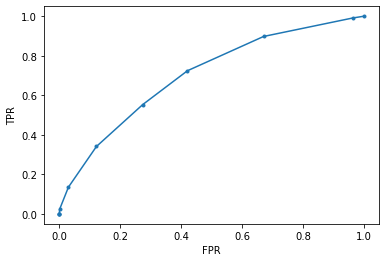

In [289]:
positives = (y_test == 1).sum()
negatives = (y_test == 0).sum()
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n = len(thresholds)
fpr = [0]*n
tpr = [0]*n
for i in range(n):
    predictions = delay.predict(X_test) >= thresholds[i]
    true_positives = ((predictions == True) & (y_test == 1)).sum()
    false_positives = ((predictions == True) & (y_test == 0)).sum()
    fpr[i] = false_positives / negatives
    tpr[i] = true_positives / positives

plt.plot(fpr,tpr,'.-')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [284]:
df5 = df.copy()
df5 = df5.loc[df5['AIRLINE'] == 'DL']
df5 = df5.loc[df5['ORIGIN_AIRPORT'] == 'JFK']
df5 = df5[['MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_TIME', 'DEPARTURE_DELAY','SCHEDULED_TIME','DISTANCE']]
df5['Hour'] = pd.to_datetime(df5['DEPARTURE_TIME']).dt.hour
df5['Minute'] = pd.to_datetime(df5['DEPARTURE_TIME']).dt.minute
df5 = df5.drop(['DEPARTURE_TIME'], axis=1)

In [285]:
df5.dropna(axis=0,how = "any",inplace=True)
X = df5[['MONTH', 'DAY', 'DAY_OF_WEEK','Hour', 'Minute', 'DISTANCE']]
Y = df5['DEPARTURE_DELAY']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
Yhat = model.predict(X) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     248.9
Date:                Sun, 23 May 2021   Prob (F-statistic):          2.28e-310
Time:                        07:08:35   Log-Likelihood:            -1.2983e+05
No. Observations:               25103   AIC:                         2.597e+05
Df Residuals:                   25096   BIC:                         2.597e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1021      1.383      0.074      0.941      -2.609       2.813
MONTH          -1.4588      0.081    -18.006      0.000      -1.618      -1.300
DAY            -0.0982      0.031     -3.194      0.001      -0.158      -0.038
DAY_OF_WEEK     0.2974      0.135      2.208      0.027       0.033       0.561
Hour            1.9012      0.056     33.682      0.000       1.791       2.012
Minute         -0.0303      0.014     -2.090      0.037      -0.059      -0.002
DISTANCE       -0.0011      0.000     -3.025      0.002      -0.002      -0.000
==============================================================================
Omnibus:                    33667.620   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13545712.246
Skew:                           7.466   Prob(JB):                         0.00
Kurtosis:                     115.817   Cond. No.                     9.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""